In [1]:
import numpy as np
import numpy as np
from numba import cuda
import re

In [2]:
corpus ="The DC Comics universe is home to iconic superheroes and villains. Characters like Superman, Batman, Wonder Woman, and The Flash have captivated readers for decades. With their superhuman abilities, they protect the world from evil forces and fight for justice.Superman, also known as Clark Kent, is an alien from the planet Krypton. His superpowers, including super strength, flight, and heat vision, make him nearly invincible. He uses his powers to defend Earth from threats like Lex Luthor and General Zod.Batman, whose real identity is Bruce Wayne, is a billionaire playboy by day and a crime-fighting vigilante by night. He has no superpowers but relies on his intellect, gadgets, and martial arts skills to take down criminals in Gotham City. His iconic symbol, the Bat-Signal, lights up the sky as a call for help.Wonder Woman, known as Diana Prince, is an Amazonian warrior princess. With her superhuman strength, agility, and her indestructible bracelets and Lasso of Truth, she fights for peace, love, and gender equality. She hails from the hidden island of Themyscira.The Flash, or Barry Allen, is the fastest man alive. He gained his speed through a freak accident, allowing him to run at incredible speeds and tap into the Speed Force. With his red suit and lightning bolt emblem, he uses his powers to protect Central City from threats like Zoom and Reverse-Flash.These characters, among many others in the DC Comics universe, have become pop culture icons through comics, movies, and TV shows. Their stories of heroism, sacrifice, and overcoming adversity continue to inspire fans around the world."
#preprocessing and removing any stopwords
# corpus='hi my name is maaz and i love batman. I love computer science. I love computer engineering too'
def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())
text = tokenize(corpus)
print(text)
print(len(text))
vocabsize = len(text)


['the', 'dc', 'comics', 'universe', 'is', 'home', 'to', 'iconic', 'superheroes', 'and', 'villains', 'characters', 'like', 'superman', 'batman', 'wonder', 'woman', 'and', 'the', 'flash', 'have', 'captivated', 'readers', 'for', 'decades', 'with', 'their', 'superhuman', 'abilities', 'they', 'protect', 'the', 'world', 'from', 'evil', 'forces', 'and', 'fight', 'for', 'justice', 'superman', 'also', 'known', 'as', 'clark', 'kent', 'is', 'an', 'alien', 'from', 'the', 'planet', 'krypton', 'his', 'superpowers', 'including', 'super', 'strength', 'flight', 'and', 'heat', 'vision', 'make', 'him', 'nearly', 'invincible', 'he', 'uses', 'his', 'powers', 'to', 'defend', 'earth', 'from', 'threats', 'like', 'lex', 'luthor', 'and', 'general', 'zod', 'batman', 'whose', 'real', 'identity', 'is', 'bruce', 'wayne', 'is', 'a', 'billionaire', 'playboy', 'by', 'day', 'and', 'a', 'crime', 'fighting', 'vigilante', 'by', 'night', 'he', 'has', 'no', 'superpowers', 'but', 'relies', 'on', 'his', 'intellect', 'gadgets'

In [3]:
def mapping(preprocessedtext):
    wordtoid=dict()
    idtoword=dict()
    for i in range(len(preprocessedtext)):
        wordtoid[preprocessedtext[i]]=i
        
        idtoword[i]=preprocessedtext[i]
    return wordtoid,idtoword
wordtoid,idtoword=mapping(text)

print(wordtoid)
print(idtoword)





{'the': 265, 'dc': 238, 'comics': 247, 'universe': 240, 'is': 182, 'home': 5, 'to': 261, 'iconic': 123, 'superheroes': 8, 'and': 257, 'villains': 10, 'characters': 232, 'like': 226, 'superman': 40, 'batman': 81, 'wonder': 137, 'woman': 138, 'flash': 230, 'have': 241, 'captivated': 21, 'readers': 22, 'for': 163, 'decades': 24, 'with': 208, 'their': 252, 'superhuman': 150, 'abilities': 28, 'they': 29, 'protect': 221, 'world': 266, 'from': 224, 'evil': 34, 'forces': 35, 'fight': 37, 'justice': 39, 'also': 41, 'known': 139, 'as': 140, 'clark': 44, 'kent': 45, 'an': 144, 'alien': 48, 'planet': 51, 'krypton': 52, 'his': 218, 'superpowers': 104, 'including': 55, 'super': 56, 'strength': 151, 'flight': 58, 'heat': 60, 'vision': 61, 'make': 62, 'him': 196, 'nearly': 64, 'invincible': 65, 'he': 216, 'uses': 217, 'powers': 219, 'defend': 71, 'earth': 72, 'threats': 225, 'lex': 76, 'luthor': 77, 'general': 79, 'zod': 80, 'whose': 82, 'real': 83, 'identity': 84, 'bruce': 86, 'wayne': 87, 'a': 192, 

In [4]:
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

def concat(*iterables):
    result = []
    for iterable in iterables:
        result.extend(iterable)
    return result

    

In [5]:
np.random.seed(42)

def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(tokens)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(tokens)))
    
    return np.asarray(X), np.asarray(y)

x,y = generate_training_data(text,word_to_id=wordtoid, window=2)
print(x.shape)
print(y.shape)


(1062, 267)
(1062, 267)


defining functions

In [6]:
np.random.seed(42)

def init_network(vocabsize,n_embedding):
    model={
        'W1':np.random.randn(vocabsize,n_embedding),
        'W2':np.random.randn(n_embedding,vocabsize)
        }
    return model
model=init_network(vocabsize,5)
print(model['W1'].shape[1])



5


In [8]:
def softmax(matrix):
    res =[]
    for i in range(len(matrix)):
        res.append(np.exp(matrix[i])/np.sum(np.exp(matrix[i])))
    return np.asarray(res)

In [9]:
#forward prop
def forward(model,X,returncache=True):
    cache ={}
    cache['z1']=np.dot(X,model['W1'])
    cache['z2'] = np.dot(cache["z1"],model["W2"])
    cache['probs'] = softmax(cache["z2"])
    if not returncache:
        return cache['z1']
    return cache
forward(model,x,True)



{'z1': array([[-1.97546657, -0.93933539, -0.14408756, -1.20969474,  0.59992873],
        [-1.97546657, -0.93933539, -0.14408756, -1.20969474,  0.59992873],
        [ 0.10537551, -1.33402549, -0.60136764,  0.31978193, -1.59299373],
        ...,
        [-1.97546657, -0.93933539, -0.14408756, -1.20969474,  0.59992873],
        [ 1.53075083,  1.21876185, -0.21344287,  1.49072614,  0.14866746],
        [ 1.53075083,  1.21876185, -0.21344287,  1.49072614,  0.14866746]]),
 'z2': array([[ 1.04568358,  1.25189453,  3.38506669, ...,  0.5166212 ,
         -0.52859403, -0.57194014],
        [ 1.04568358,  1.25189453,  3.38506669, ...,  0.5166212 ,
         -0.52859403, -0.57194014],
        [ 1.53857919, -0.50401013, -1.79022429, ..., -0.07745122,
         -2.13268377,  0.77375631],
        ...,
        [ 1.04568358,  1.25189453,  3.38506669, ...,  0.5166212 ,
         -0.52859403, -0.57194014],
        [-1.10413218,  0.8809661 , -2.65336812, ..., -1.24143083,
          1.51448435,  0.17545683],


In [10]:
@cuda.jit
def matrix_multiply(A, B, C, D, E):
    i, j = cuda.grid(2)
    if i < E.shape[0] and j < E.shape[1]:
        temp = 0.0
        for k in range(A.shape[1]):
            temp += A[i, k] * B[k, j]
        C[i, j] = temp
        cuda.syncthreads()

        # Matrix multiplication of C and D
        temp = 0.0
        for k in range(C.shape[1]):
            temp += C[i, k] * D[k, j]
        E[i, j] = temp

In [11]:
def forwardprop_using_cuda(input_matrix, weight_matrix1, weight_matrix2,returncache=True):
    # Transfer input matrices to the GPU
    x_input_cuda = cuda.to_device(input_matrix)
    w1_input_cuda = cuda.to_device(weight_matrix1)
    w2_input_cuda = cuda.to_device(weight_matrix2)

    # Create CUDA device arrays for intermediate results
    z1_cuda = cuda.device_array((input_matrix.shape[0], weight_matrix1.shape[1]), dtype=np.float64)
    z2_cuda = cuda.device_array((input_matrix.shape[0], weight_matrix2.shape[1]), dtype=np.float64)

    # Set the block and grid dimensions
    threadsperblock = (16, 16)
    blockspergrid_x = (input_matrix.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
    blockspergrid_y = (weight_matrix1.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Launch the kernel for the first matrix multiplication
    matrix_multiply[blockspergrid, threadsperblock](x_input_cuda, w1_input_cuda, z1_cuda, w2_input_cuda, z2_cuda)
    cuda.synchronize()

    # Copy the final result back to the host
    cache = {}
    cache['z1'] = z1_cuda.copy_to_host()
    cache['z2'] = z2_cuda.copy_to_host()
    cache['probs'] = softmax(cache["z2"])
    if not returncache:
        return cache['probs']
    return cache

In [12]:
forwardprop_using_cuda(x,model['W1'],model['W2'],True)
# learning = one_hot_encode(wordtoid['comics'], len(text))
# print(model['W1'].shape[1])
# forwardprop_using_cuda(learning,model,False)



c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\cuda\dispatcher.py:539: NumbaPerformanceWarning: Grid size 67 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


{'z1': array([[-1.97546657, -0.93933539, -0.14408756, -1.20969474,  0.59992873],
        [ 1.53075083,  1.21876185, -0.21344287,  1.49072614,  0.14866746],
        [ 0.        ,  1.21876185, -0.21344287,  1.49072614,  0.        ],
        ...,
        [ 1.53075083,  0.        , -0.14408756, -1.20969474,  0.59992873],
        [ 1.53075083,  0.        , -0.21344287,  1.49072614,  0.14866746],
        [ 0.        ,  0.        , -0.21344287,  1.49072614,  0.14866746]]),
 'z2': array([[ 1.04568358,  1.25189453,  3.38506669, ...,  0.        ,
          0.        ,  0.        ],
        [-1.10413218,  0.8809661 , -2.65336812, ...,  0.        ,
          0.        ,  0.        ],
        [-0.54775128,  1.57114488, -2.38964533, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.74299013, -1.6495379 ,  1.87108413, ...,  0.        ,
          0.        ,  0.        ],
        [-0.31685568,  1.85499083, -2.06501873, ...,  0.        ,
          0.        ,  0.        ],


In [13]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

In [399]:
def backward(model, X, y, alpha):
    cache  = forwardprop_using_cuda(X,model['W1'],model['W2'],True)
    cache  = forward(model, X)
    da2 = cache["probs"] - y
    dw2 = cache["z1"].T @ da2
    da1 = da2 @ model["W2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["W2"].shape)
    assert(dw1.shape == model["W1"].shape)
    model["W1"] -= alpha * dw1
    model["W2"] -= alpha * dw2
    return cross_entropy(cache["probs"], y)

C:\Users\HP\AppData\Local\Temp\ipykernel_1064\1503733050.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


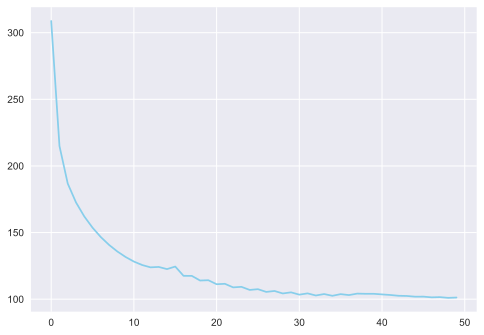

In [400]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

n_iter = 50
learning_rate = 0.05

history = [backward(model, x, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [401]:
learning = one_hot_encode(wordtoid["batman"], len(text))
result = forward(model, [learning],False)[0]

for word in (idtoword[id] for id in np.argsort(result)[::-1]):
    print(word)

my
hi
name
is
maaz
